# Localization Model

## Import Libraries and Data

In [1]:
import time 
import pickle

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

from matplotlib.colors import Normalize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

np.random.seed(0)
torch.manual_seed(0)

In [2]:
path = 'Data/ui_data_2.csv'  
data = pd.read_csv(path)
print(data.shape)

(6596, 10)


## Pre-Checks

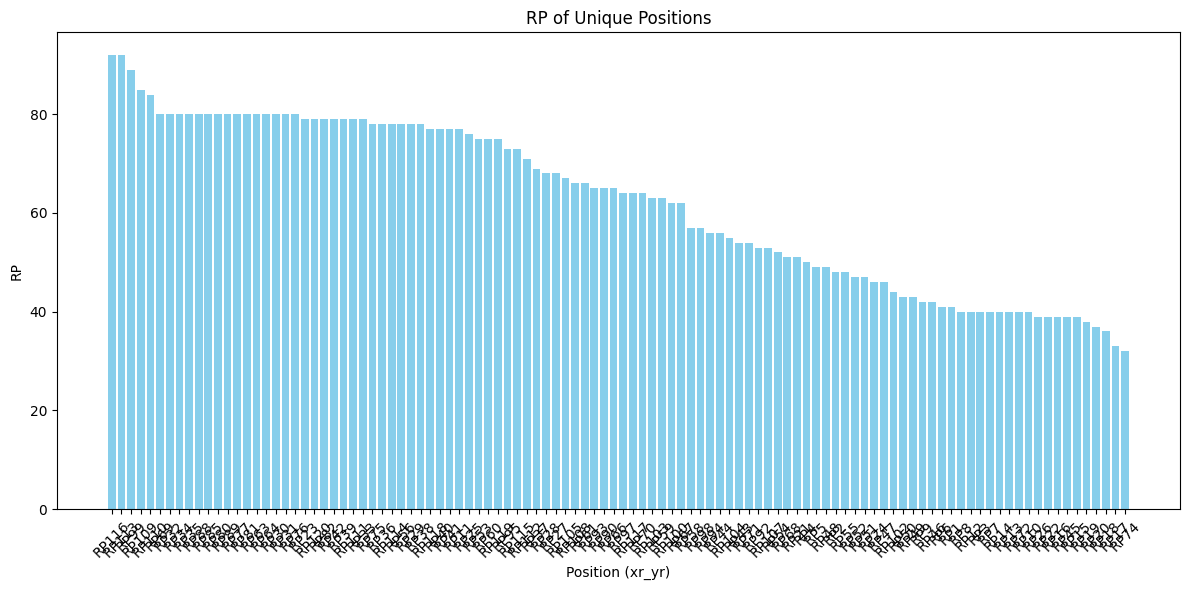

In [3]:
# Step 2: Count the frequency of each unique position
frequency = data['reference_point'].value_counts()

# If you want to reset the index and get a DataFrame
frequency_df = frequency.reset_index()
frequency_df.columns = ['reference_point', 'frequency']

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(frequency_df['reference_point'], frequency_df['frequency'], color='skyblue')
plt.xlabel('Position (xr_yr)')
plt.ylabel('RP')
plt.title('RP of Unique Positions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [4]:
data['rssi_ap_dosen'].unique()

array([  nan,  -96.,  -94.,  -95.,  -92.,  -97.,  -90.,  -89.,  -91.,
        -93.,  -86.,  -88.,  -87.,  -81.,  -82.,  -83.,  -84.,  -85.,
        -79.,  -80.,  -78.,  -77.,  -75.,  -70.,  -71.,  -72.,  -73.,
        -74.,  -63.,  -64.,  -62.,  -76.,  -98.,  -99., -100.,  -69.,
        -66.,  -67.,  -65.,  -68.,  -37.,  -41.,  -40.,  -36.,  -38.,
        -35.,  -39.,  -43.,  -42.,  -44.,  -47.,  -45.])

In [5]:
data['rssi_ap_digilab'].unique()

array([-64., -63., -65., -62., -61., -60., -67., -71.,  nan, -70., -66.,
       -68., -69., -74., -75., -72., -73., -59., -57., -58., -43., -42.,
       -44., -45., -41., -39., -50., -51., -46., -47., -52., -53., -54.,
       -55., -56., -76., -77., -81., -80., -79., -78., -49., -48., -83.,
       -82., -86., -87., -84., -85., -89., -88., -90., -91., -34., -36.,
       -37., -40., -38., -35.])

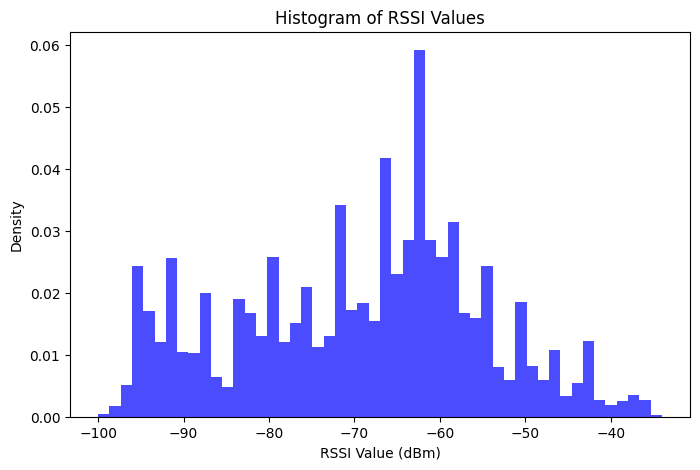

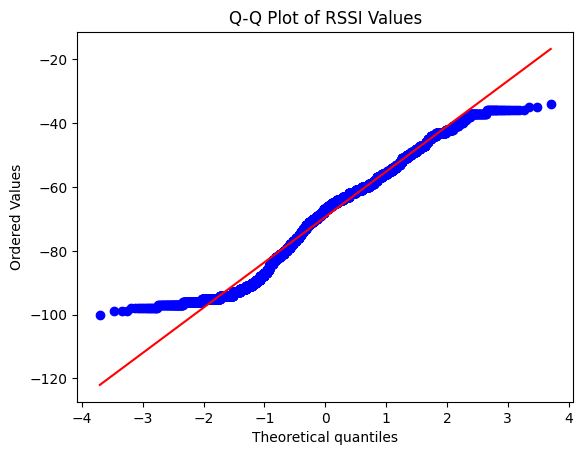

RSSI Skewness: -0.1302
RSSI Kurtosis: -0.6852


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import skew, kurtosis

# Select RSSI columns (replace with actual column names from your dataset)
rssi_digilab = data["rssi_ap_digilab"]
rssi_dosen = data["rssi_ap_dosen"]

rssi_digilab = rssi_digilab[rssi_digilab > -200]
rssi_dosen = rssi_dosen[rssi_dosen > -200]

# Combine both RSSI columns for analysis
rssi_values = np.concatenate([rssi_digilab, rssi_dosen])

# 1️⃣ Histogram (Check RSSI Distribution)
plt.figure(figsize=(8, 5))
plt.hist(rssi_values, bins=50, color='blue', alpha=0.7, density=True)
plt.xlabel("RSSI Value (dBm)")
plt.ylabel("Density")
plt.title("Histogram of RSSI Values")
plt.show()

# 2️⃣ Q-Q Plot (Check for Normality)
stats.probplot(rssi_values, dist="norm", plot=plt)
plt.title("Q-Q Plot of RSSI Values")
plt.show()

# 3️⃣ Skewness & Kurtosis (Numerical Analysis)
rssi_skewness = skew(rssi_values)
rssi_kurtosis = kurtosis(rssi_values)

print(f"RSSI Skewness: {rssi_skewness:.4f}")  # >0 means right-skewed, <0 means left-skewed
print(f"RSSI Kurtosis: {rssi_kurtosis:.4f}")  # >3 means heavy-tailed (outliers)


## Handling Missing Values (NaN)

In [7]:
# Fill missing RSSI values
data['rssi_ap_digilab'] = data['rssi_ap_digilab'].fillna(-200)
data['rssi_ap_dosen'] = data['rssi_ap_dosen'].fillna(-200)

## Real AP Coordinates

In [8]:
ap_coordinates = {
    'DTE Staff (Digilab)': (867, 1122),
    'DTE Staff (Dosen)': (2454, 520)
}

## Relative Position Column Insertion

In [9]:
data = data[~data['reference_point'].isin(['RP49', 'RP74'])]

# Ensure the relative_position column exists with a default numeric value (-1 for unassigned)
data['relative_position'] = -1  # Using -1 to indicate unassigned values initially

# Define reference points that should be assigned a relative position of 0
zero_rps = (
    list(range(1, 21)) +   # RP1-20
    list(range(53, 57)) +  # RP53-56
    list(range(58, 62)) +  # RP58-61
    list(range(63, 65)) +  # RP63-64
    list(range(66, 73)) +  # RP66-72
    list(range(75, 78)) +  # RP75-77
    list(range(80, 89)) +  # RP80-88
    list(range(113, 116)) +  # RP113-115
    list(range(118, 121)) +  # RP118-120
    list(range(93, 96)) +
    list(range(98, 101)) +
    list(range(103, 106)) +
    list(range(108, 111)) 
)

# Define reference points that should be assigned a relative position of 1
one_rps = list(range(28, 43)) + [89, 90]  # RP28-42 and RP89-90


# Convert lists to sets for faster lookup
zero_rp_set = {f'RP{i}' for i in zero_rps}
one_rp_set = {f'RP{i}' for i in one_rps}

# Apply conditions to assign relative_position
data['relative_position'] = data['reference_point'].apply(
    lambda rp: 0 if rp in zero_rp_set else (1 if rp in one_rp_set else -1)
)

# Convert to integer type to ensure it's numeric
data['relative_position'] = data['relative_position'].astype(int)

# Check unique values to ensure no -1 remains
print("Unique values in relative_position:", data['relative_position'].unique())

# Check the first few rows to confirm the relative_position column was added correctly
print(data[['reference_point', 'relative_position']].head())

Unique values in relative_position: [ 0  1 -1]
  reference_point  relative_position
0             RP1                  0
1             RP1                  0
2             RP1                  0
3             RP1                  0
4             RP1                  0


In [10]:
# Convert the 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'])
# Convert to seconds since the epoch
data['time_numeric'] = data['time'].apply(lambda x: x.time())

## BSSID Mapping (Encoding)

In [11]:
# Define the mapping dictionary
bssid_mapping = {
    '70:a7:41:dc:8e:55': 1,
    '72:a7:41:9c:8e:55': 2,
    '70:a7:41:dc:77:cd': 3,
    '72:a7:41:9c:77:cd': 4
}

In [12]:
data['bssid'] = data['bssid'].map(bssid_mapping)
print(data[['bssid', 'bssid']].head())


   bssid  bssid
0      4      4
1      3      3
2      4      4
3      4      4
4      3      3


In [13]:
# Assuming 'reference_point' is your column name in the DataFrame
data['reference_point'] = data['reference_point'].str.replace('RP', '').astype(int)

# Check the result
print(data['reference_point'])

0         1
1         1
2         1
3         1
4         1
       ... 
6591    116
6592    116
6593    116
6594    116
6595    116
Name: reference_point, Length: 6521, dtype: int32


In [14]:
data.sample(10)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric
3033,2025-03-01 01:59:27.335825500+00:00,81,2,DTE Staff,1,11,2000,639,-200.0,-77.0,0,01:59:27.335825
2630,2025-03-01 00:54:50.339890600+00:00,58,13,DTE Student,4,1,1653,1368,-69.0,-200.0,0,00:54:50.339890
4947,2025-03-03 08:24:48.300412700+00:00,99,13,DTE Student,4,6,720,639,-60.0,-200.0,0,08:24:48.300412
1514,2024-10-23 07:48:40.296645800+00:00,39,13,DTE Student,4,11,2224,1037,-61.0,-200.0,1,07:48:40.296645
3652,2025-03-01 03:35:24.305702900+00:00,63,10,DTE Staff,1,11,1826,1368,-200.0,-80.0,0,03:35:24.305702
3046,2025-03-01 02:00:59.104510+00:00,81,6,DTE Staff,3,1,2000,639,-60.0,-200.0,0,02:00:59.104510
4423,2025-03-03 07:11:51.092943800+00:00,110,18,DTE Student,4,6,1120,838,-40.0,-200.0,0,07:11:51.092943
5350,2025-03-11 07:38:23.544969100+00:00,51,3,DTE Staff,3,6,1341,1948,-62.0,-200.0,-1,07:38:23.544969
5575,2025-03-11 08:26:07.058083500+00:00,25,18,DTE Staff,3,6,529,1037,-58.0,-200.0,-1,08:26:07.058083
5668,2025-03-11 08:48:41.882742900+00:00,21,3,DTE Staff,3,6,70,1037,-54.0,-200.0,-1,08:48:41.882742


In [15]:
# # Save the final dataframe
# data.to_csv('data_preprocessed.csv', index=False)
# print(f"Data saved to {'data_preprocessed.csv'}")

## Encoder (Still Template)

In [16]:
# def encode_and_save_labels(data, column_name, encoder_file_name='label_encoder.pkl'):
#     # Initialize the LabelEncoder
#     le = LabelEncoder()
    
#     # Fit and transform the data
#     encoded_values = le.fit_transform(data[column_name])
    
#     # Replace the original column with encoded values
#     data[column_name] = encoded_values
    
#     # Save the encoder to a file
#     with open(encoder_file_name, 'wb') as file:
#         pickle.dump(le, file)
    
#     print(f"Encoded {column_name} and saved encoder to {encoder_file_name}")
    
#     return data

# def decode_labels(data, column_name, encoder_file_name='label_encoder.pkl'):
#     # Load the encoder from the file
#     with open(encoder_file_name, 'rb') as file:
#         le = pickle.load(file)
    
#     # Transform the encoded values back to original labels
#     decoded_values = le.inverse_transform(data[column_name])
    
#     # Replace the encoded column with decoded values
#     data[column_name] = decoded_values
    
#     print(f"Decoded {column_name} using encoder from {encoder_file_name}")
    
#     return data

# def decode_predictions(y_pred, encoder_file_name='label_encoder.pkl'):
#     # Load the encoder from the file
#     with open(encoder_file_name, 'rb') as file:
#         le = pickle.load(file)
    
#     # Transform the encoded predictions back to original labels
#     decoded_predictions = le.inverse_transform(y_pred)
    
#     print(f"Decoded predictions using encoder from {encoder_file_name}")
    
#     return decoded_predictions

## Handling Overlapping Data


In [17]:
print("Columns in DataFrame:", data.columns)
print("Shape of DataFrame:", data.shape)

Columns in DataFrame: Index(['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel',
       'xr', 'yr', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position',
       'time_numeric'],
      dtype='object')
Shape of DataFrame: (6521, 12)


In [18]:
df = data.iloc[:, [1, 2, 4, 5, 8 , 9, 10]]
print("\nColumns in X:", df.columns.tolist())

# df = encode_and_save_labels(df, 'reference_point')
df = df.rename(columns={'reference_point': 'label'})


Columns in X: ['reference_point', 'iteration', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']


In [19]:
df

,label,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position
0,1,3,4,11,-64.0,-200.0,0
1,1,1,3,11,-63.0,-200.0,0
2,1,1,4,11,-63.0,-200.0,0
3,1,2,4,11,-64.0,-200.0,0
4,1,2,3,11,-65.0,-200.0,0
...,...,...,...,...,...,...,...
6591,116,19,1,11,-200.0,-82.0,-1
6592,116,20,3,6,-65.0,-200.0,-1
6593,116,20,4,6,-65.0,-200.0,-1
6594,116,20,2,11,-200.0,-84.0,-1


### Are there overlapping points?

In [20]:
binned_data = df.copy()
binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
overlapping_points = overlapping_points[overlapping_points > 1]
overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

overlapping_data

,,,,,,relative_position
label,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,


In [21]:
# Delete overlapping data 
non_overlapping_mask = ~binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_points.index)
df = df[non_overlapping_mask]
df.shape

(6521, 7)

## Regression Model

### Feature Selection

In [22]:
X = data.iloc[:, [1, 4, 5, 8 , 9, 10]]
y = data.iloc[:, [6, 7]]


In [23]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']
Columns in y: ['xr', 'yr']


In [24]:
print(X.head())
print(X.dtypes)

   reference_point  bssid  channel  rssi_ap_digilab  rssi_ap_dosen  \
0                1      4       11            -64.0         -200.0   
1                1      3       11            -63.0         -200.0   
2                1      4       11            -63.0         -200.0   
3                1      4       11            -64.0         -200.0   
4                1      3       11            -65.0         -200.0   

   relative_position  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
reference_point        int32
bssid                  int64
channel                int64
rssi_ap_digilab      float64
rssi_ap_dosen        float64
relative_position      int32
dtype: object


### Robust Scaler + Assign Train & Validation 

In [25]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    

regression_data_scaled = RobustScaler().fit_transform(X)

dataset = CustomDataset(regression_data_scaled, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataset = CustomDataset(regression_data_scaled, y)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [26]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']
Columns in y: ['xr', 'yr']


### Split Training & Full Testing set

In [27]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Ensure y is a numpy array
y = np.array(y)  # Convert to numpy array if y is a pandas DataFrame or Series

# Step 1: Split the dataset into 70% training, 30% remaining (not final test set)
X_train, X_unused, y_train, y_unused = train_test_split(regression_data_scaled, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

# Step 2: Use 100% of the dataset as the test set
X_test = regression_data_scaled  # Full dataset as test set
y_test = y  # Full dataset labels

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]} (Full Dataset)")

Training set size: 4016
Test set size: 6521 (Full Dataset)


In [28]:
print(f"Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")


Training samples: 4016, Features: 6


### XGB Hyperparameter Tuning

In [29]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    max_depth=6,  # Increase depth for more complex patterns
    learning_rate=0.05,  # Reduce step size for better accuracy
    n_estimators=500  # More trees for better generalization
)

# Use MultiOutputRegressor to handle multiple targets
multi_xgb = MultiOutputRegressor(xgb_model)

In [30]:
# Define hyperparameters for tuning
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.01, 0.1, 0.3]
}

### Outlier Handling

In [31]:
def remove_outliers_before_training(X, y, threshold=1000):
    """Remove samples where MSE is an outlier before training the model."""
    # Predict rough initial values using a simple model to estimate errors
    temp_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
    temp_model.fit(X, y)
    y_pred = temp_model.predict(X)
    
    # Compute errors
    mse = np.mean((y - y_pred)**2, axis=1)
    
    # Keep only samples with MSE below the threshold
    mask = mse < threshold
    return X[mask], y[mask]

In [32]:
X_train, y_train = remove_outliers_before_training(X_train, y_train, threshold=1000)

### Model Training

In [33]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constr...
                                                                   max_depth=6,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=500,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=42, ...)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.1, 0.3],
                         'estimator__max_depth': [3, 4, 5],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [34]:
# Print the best parameters
print("Best parameters found by grid search:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_model = grid_search.best_estimator_

# Print all hyperparameters of the best model
print("\nAll hyperparameters of the best model:")
for i, estimator in enumerate(best_model.estimators_):
    print(f"\nEstimator for dimension {i+1} ({'x' if i==0 else 'y' if i==1 else 'z'}):")
    for param, value in estimator.get_params().items():
        print(f"  {param}: {value}")

Best parameters found by grid search:
estimator__learning_rate: 0.3
estimator__max_depth: 4
estimator__n_estimators: 300

All hyperparameters of the best model:

Estimator for dimension 1 (x):
  objective: reg:squarederror
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: None
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.3
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 4
  max_leaves: None
  min_child_weight: None
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: 300
  n_jobs: None
  num_parallel_tree: None
  random_state: 42
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: None
  tree_method: None
 

In [35]:
# Make predictions
y_pred = best_model.predict(X_test)

### Model Evaluation

In [36]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Number of predictions: {len(y_pred)}")
print(f"\nOverall Mean Squared Error: {mse}")

# Calculate and print MSE for each coordinate
for i, coord in enumerate(['x', 'y']):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    print(f"MSE for {coord}: {mse}")

Number of predictions: 6521

Overall Mean Squared Error: 61.4479866027832
MSE for x: 3.161595106124878
MSE for y: 119.734375


In [37]:
# # Function to compute MSE statistics and remove outliers
# def remove_mse_outliers(y_true, y_pred, percentile=95):
#     """Removes high-MSE outliers based on a given percentile threshold."""
    
#     # Compute MSE per sample
#     mse_per_sample = np.mean((y_true - y_pred) ** 2, axis=1)
    
#     # Compute MSE statistics BEFORE filtering
#     stats_before = {
#         "Mean MSE": np.mean(mse_per_sample),
#         "Median MSE": np.median(mse_per_sample),
#         "Max MSE": np.max(mse_per_sample),
#         "Min MSE": np.min(mse_per_sample),
#         "Std Dev MSE": np.std(mse_per_sample),
#     }

#     # Compute percentile threshold for outlier detection
#     threshold = np.percentile(mse_per_sample, percentile)
    
#     # Create mask for non-outliers (values below the threshold)
#     mask = mse_per_sample < threshold
    
#     # Apply mask to filter `y_test` and `y_pred`
#     y_test_filtered = y_true[mask]
#     y_pred_filtered = y_pred[mask]
    
#     # Compute MSE statistics AFTER filtering
#     mse_per_sample_filtered = mse_per_sample[mask]
#     stats_after = {
#         "Mean MSE": np.mean(mse_per_sample_filtered),
#         "Median MSE": np.median(mse_per_sample_filtered),
#         "Max MSE": np.max(mse_per_sample_filtered),
#         "Min MSE": np.min(mse_per_sample_filtered),
#         "Std Dev MSE": np.std(mse_per_sample_filtered),
#     }

#     # Display comparison of MSE statistics
#     mse_comparison = pd.DataFrame([stats_before, stats_after], index=["Before Outlier Removal", "After Outlier Removal"])
    
#     return mse_comparison, y_test_filtered, y_pred_filtered

# # Ensure correct test set subset matches prediction size
# mse_stats, y_test_filtered, y_pred_filtered = remove_mse_outliers(y_test[:len(y_pred)], y_pred, percentile=95)

# # Display MSE statistics comparison
# print("\nMSE Statistics Before and After Outlier Removal:")
# print(mse_stats)

# # Compute new MSE after outlier removal
# mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
# print(f"\nOverall Mean Squared Error (After Outlier Removal): {mse_filtered}")

# # Calculate and print MSE for each coordinate (x, y)
# for i, coord in enumerate(['x', 'y']):
#     mse_coord = mean_squared_error(y_test_filtered[:, i], y_pred_filtered[:, i])
#     print(f"MSE for {coord} (After Outlier Removal): {mse_coord}")


### Floorplan Prediction visualization

In [38]:
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# from matplotlib.colors import Normalize
# from sklearn.metrics import mean_squared_error

# def plot_2d_ap_positions_with_floorplan(y_true, y_pred, floorplan_path, real_to_pixel_scale=None):
#     # Load the floor plan image
#     floorplan = cv2.imread(floorplan_path)
#     floorplan = cv2.cvtColor(floorplan, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

#     # Get image dimensions
#     img_height, img_width, _ = floorplan.shape

#     # If a scaling factor is provided, transform real-world coordinates to pixel space
#     if real_to_pixel_scale:
#         y_true = y_true * real_to_pixel_scale
#         y_pred = y_pred * real_to_pixel_scale

#     # Flip only the Y-coordinates of the predictions
#     y_pred[:, 1] = img_height - y_pred[:, 1]
#     y_true[:, 1] = img_height - y_true[:, 1]  # Optional: If ground truth also needs flipping

#     # Calculate MSE for each point
#     mse = np.mean((y_true - y_pred) ** 2, axis=1)

#     print(f"Number of predictions: {len(y_pred)}")

#     # Create the 2D plot with the floor plan as the background
#     plt.figure(figsize=(12, 10))
#     plt.imshow(floorplan, extent=[0, img_width, img_height, 0])  # Floor plan remains in place

#     # Plot ground truth positions in red
#     plt.scatter(y_true[:, 0], y_true[:, 1], 
#                 c='red', marker='o', s=100, alpha=1, label='Ground Truth')

#     # Adjust normalization range based on the MSE values
#     norm = Normalize(vmin=mse.min(), vmax=mse.max())

#     # Plot predicted positions with color based on MSE
#     scatter = plt.scatter(y_pred[:, 0], y_pred[:, 1],
#                           c=mse, norm=norm, cmap='plasma', s=50, alpha=0.9, label='Predicted')

#     # Add colorbar
#     cbar = plt.colorbar(scatter)
#     cbar.set_label('Mean Squared Error')

#     # Calculate overall MSE
#     overall_mse = mean_squared_error(y_true, y_pred)

#     plt.xlabel('X Position')
#     plt.ylabel('Y Position')
#     plt.legend()
#     plt.title(f'AP Positions on Floor Plan - Overall MSE: {overall_mse:.4f}')

#     plt.tight_layout()
#     plt.show()

# # Example usage
# floorplan_path = "Data/floorplan.png"  # Update this to your floorplan image path
# plot_2d_ap_positions_with_floorplan(y_test, y_pred, floorplan_path)

### Save the Model

In [39]:
# Create a DataFrame for predictions
predicted_df = pd.DataFrame({
    'xp': y_pred[:, 0],  # Predicted x-coordinate
    'yp': y_pred[:, 1]   # Predicted y-coordinate
})

# Reset index to ensure alignment before merging
predicted_df = predicted_df.reset_index(drop=True)
merged_data = data.copy().reset_index(drop=True)

# Ensure the row count matches before merging
if len(predicted_df) < len(merged_data):
    merged_data = merged_data.iloc[:len(predicted_df)]  # Trim extra rows

# Add predictions while ensuring proper alignment
merged_data[['xp', 'yp']] = predicted_df.values

# Verify
print(merged_data[['xr', 'yr', 'xp', 'yp']].sample(5))  # Check first few rows

        xr    yr           xp           yp
3283  1826  2130  1826.051880  2128.336914
1624  1678  1037  1677.921997  1044.347778
4955   720   639   720.017456   639.134888
2582  1479  1789  1478.826294  1823.287476
797    759  1749   758.941284  1748.544067


In [40]:
merged_data.shape

(6521, 14)

In [41]:
merged_data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
461,2024-10-17 10:22:35.674944+00:00,29,8,DTE Staff,2,1,989,1037,-200.0,-90.0,1,10:22:35.674944,989.044922,1036.405029
4590,2025-03-03 07:38:51.986071700+00:00,95,19,DTE Student,4,6,520,838,-61.0,-200.0,0,07:38:51.986071,519.957703,837.800293
4269,2025-03-01 05:05:49.897803100+00:00,90,11,DTE Staff,3,1,2454,1393,-70.0,-200.0,1,05:05:49.897803,2453.976074,1391.606812
3173,2025-03-01 02:15:46.380422700+00:00,82,18,DTE Student,4,1,2000,838,-68.0,-200.0,0,02:15:46.380422,1999.986328,837.230042
1288,2024-10-23 07:15:58.669012900+00:00,42,15,DTE Staff,3,11,2454,1202,-65.0,-200.0,1,07:15:58.669012,2453.615723,1199.065308


In [42]:
# Create a new dataframe from merged_data
woi_filtered_data = merged_data.copy()

# Count the number of rows before filtering
rows_before = len(woi_filtered_data)

# Remove rows where the difference in either yr-yp or xr-xp is more than 20
woi_filtered_data = woi_filtered_data[
    (abs(woi_filtered_data['yr'] - woi_filtered_data['yp']) < 5) &
    (abs(woi_filtered_data['xr'] - woi_filtered_data['xp']) < 5)
]

# Count the number of rows after filtering
rows_after = len(woi_filtered_data)

# Calculate the number of removed rows
rows_removed = rows_before - rows_after

# Display results
print(f"Rows removed: {rows_removed}")
print(f"Rows remaining: {rows_after}")


Rows removed: 1090
Rows remaining: 5431


In [43]:
woi_filtered_data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
5392,2025-03-11 07:51:33.257156200+00:00,47,16,DTE Staff,3,6,1168,2130,-61.0,-200.0,-1,07:51:33.257156,1168.003540,2130.960205
2309,2025-02-25 04:21:51.940981800+00:00,119,13,DTE Staff,3,1,1520,639,-59.0,-200.0,0,04:21:51.940981,1520.132324,639.599060
2220,2025-02-25 04:10:34.348903200+00:00,118,9,DTE Staff,2,11,1520,469,-200.0,-78.0,0,04:10:34.348903,1519.973145,468.272186
9,2024-10-17 08:41:16.590208600+00:00,1,5,DTE Staff,3,11,300,1368,-63.0,-200.0,0,08:41:16.590208,300.006104,1367.346436
5891,2025-03-12 03:23:17.015684400+00:00,48,20,DTE Staff,3,6,1341,1368,-55.0,-200.0,-1,03:23:17.015684,1341.003662,1367.505127


In [44]:
# # Extract additional columns **including raw RSSI values** from `data`
# additional_columns = data.loc[:, ['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel', 
#                                 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']]

# # Ensure `additional_columns` has the same number of rows as `y_test_filtered`
# additional_columns = additional_columns.iloc[:len(y_test_filtered)].reset_index(drop=True)

# # Create the comparison dataframe using only the filtered data
# comparison_df = pd.DataFrame({
#     'xr': y_test_filtered[:, 0],  # Actual x-coordinate
#     'yr': y_test_filtered[:, 1],  # Actual y-coordinate
#     'xp': y_pred_filtered[:, 0],  # Predicted x-coordinate
#     'yp': y_pred_filtered[:, 1]  # Predicted y-coordinate
# })

# # Ensure `comparison_df` has the same number of rows
# comparison_df = comparison_df.iloc[:len(additional_columns)].reset_index(drop=True)

# # Concatenate additional columns (with raw RSSI) with `comparison_df`
# comparison_df = pd.concat([additional_columns, comparison_df], axis=1)

# # Display the updated comparison table shape
# comparison_df.shape


In [45]:
# # Identify if xp or yp contain -1
# columns_with_neg1 = (comparison_df[['xp', 'yp']] == -1).any()

# # Display only if `xp` or `yp` contain -1
# print("\nColumns containing -1 values (xp and yp only):")
# print(columns_with_neg1[columns_with_neg1].index.tolist())  # List of affected columns

# # Count how many rows contain -1 in `xp` or `yp`
# num_rows_with_neg1 = (comparison_df[['xp', 'yp']] == -1).any(axis=1).sum()
# print(f"\nNumber of rows containing -1 in xp or yp: {num_rows_with_neg1}")

In [46]:
# # Drop rows where any column contains -1 (invalid predictions)
# comparison_df = comparison_df[(comparison_df != -1).all(axis=1)]
# comparison_df.sample(7)

In [47]:
# Convert xp and yp to integers based on their decimal value
woi_filtered_data['xp'] = np.where(woi_filtered_data['xp'] % 1 >= 0.5, np.ceil(woi_filtered_data['xp']), np.floor(woi_filtered_data['xp'])).astype(int)
woi_filtered_data['yp'] = np.where(woi_filtered_data['yp'] % 1 >= 0.5, np.ceil(woi_filtered_data['yp']), np.floor(woi_filtered_data['yp'])).astype(int)

# Verify conversion
print(woi_filtered_data[['xp', 'yp']].sample(5))  # Check the first few rows


        xp    yp
3548  1653  1943
4549   520   838
3967  2000   469
6251  1290   135
1908  1219  1037


In [48]:
# Save the new dataset to a CSV file
woi_filtered_data.to_csv('Data/data_with_predictions.csv', index=False)

print("New CSV file 'data_with_predictions.csv' saved successfully!")

New CSV file 'data_with_predictions.csv' saved successfully!


In [49]:
merged_data['reference_point'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  29,  30,  37,
        11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  38,  36,  42,
        41,  40,  39,  35,  33,  34,  32,  31, 113, 114, 115, 118, 119,
       120,  53,  54,  55,  58,  59,  60,  77,  76,  75,  81,  82,  66,
        67,  70,  71,  72,  56,  61,  63,  64,  68,  69,  80,  89,  85,
        88,  90,  28, 110, 105, 100,  95, 109, 108, 103, 104,  99,  98,
        93,  45,  44,  43,  52,  51,  46,  47,  27,  25,  23,  21,  22,
        24,  26,  50,  48, 107, 102,  94,  97,  92, 111, 112, 117, 116])

In [50]:
woi_filtered_data['reference_point'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  29,  30,  37,
        11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  38,  36,  42,
        41,  40,  39,  35,  33,  34,  32,  31, 113, 114, 115, 118, 119,
       120,  53,  54,  55,  58,  59,  60,  77,  76,  75,  81,  82,  66,
        67,  70,  71,  72,  56,  61,  63,  64,  68,  69,  80,  89,  85,
        88,  90,  28, 110, 105, 100,  95, 109, 108, 103, 104,  99,  98,
        93,  45,  44,  43,  52,  51,  46,  47,  27,  25,  23,  21,  22,
        24,  26,  50,  48, 107, 102,  94,  97,  92, 111, 112, 117, 116])

# RSSI Prediction Model

## Remove NaN Values

In [51]:
# Remove rows with any NaN values
filtered_data = woi_filtered_data.dropna()

print(f"Filtered dataset saved successfully with {filtered_data.shape[0]} rows and {filtered_data.shape[1]} columns.")

Filtered dataset saved successfully with 5431 rows and 14 columns.


In [52]:
filtered_data.head()

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
0,2024-10-17 08:38:31.952562400+00:00,1,3,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:38:31.952562,300,1368
1,2024-10-17 08:39:38.608620600+00:00,1,1,DTE Staff,3,11,300,1368,-63.0,-200.0,0,08:39:38.608620,300,1367
2,2024-10-17 08:39:45.832622300+00:00,1,1,DTE Student,4,11,300,1368,-63.0,-200.0,0,08:39:45.832622,300,1367
3,2024-10-17 08:40:03.157448400+00:00,1,2,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:40:03.157448,300,1368
5,2024-10-17 08:40:27.631585400+00:00,1,3,DTE Student,4,11,300,1368,-62.0,-200.0,0,08:40:27.631585,300,1368


In [53]:
filtered_data.shape

(5431, 14)

In [54]:
filtered_data['xr'].unique()

array([ 300,  529,  989, 1908,  759, 1678, 2454, 2224, 1449, 1219, 1290,
       1520, 1479, 1653, 1720, 2000, 1826, 1120,  920,  720,  520, 1168,
       1341,   70], dtype=int64)

In [55]:
filtered_data['xp'].unique()

array([ 300,  529,  532,  989,  988, 1908, 1907, 1909,  759, 1678, 2454,
       2224, 2223, 2221, 2225, 1449, 1450, 1219, 1218, 1290, 1289, 1291,
       1519, 1520, 1521, 1479, 1653, 1721, 1720, 1719, 1722, 1718, 1717,
       1723, 2000, 2001, 1998, 1999, 1827, 1826, 1828, 1825, 2228, 2226,
       2453, 1120,  920,  719,  720,  721,  520, 1121, 1168, 1167, 1169,
       1341,   70, 1119, 1123, 1292])

## Transmit Power

In [56]:
reference_point_power_map = {
    "RP1-10": (30, 20),         # Digilab only, max boost
    "RP10-20": (30, 30),        # Both weak
    "RP21-28": (30, 20),
    "RP29-38": (30, 23),
    "RP39-42, 89-90": (20, 30), # Dosen dominant
    "RP43-45, 48-50": (26, 20),
    "RP46-47, 51-52": (23, 20),
    "RP53-55, 58-60": (23, 20),
    "RP56, 61": (23, 20),
    "RP63-64, 68-69": (26, 26),
    "RP85, 88": (20, 30),       # Dosen only
    "RP75-77, 80-82": (23, 30),
    "RP92-95, 97-100": (26, 26),
    "RP102-105, 107-110": (30, 23),
    "RP111-112, 116-117": (23, 30),
    "RP113-115, 118-120": (26, 26),
    "RP66-67, 70-72": (30, 20)
}



# Function to assign transmit power based on reference point
def assign_transmit_power(reference_point):
    reference_point_str = str(reference_point)  # Ensure it is a string

    for rp_range, (pow_digilab, pow_dosen) in reference_point_power_map.items():
        rp_list = rp_range.replace("RP", "").replace("-", ",").split(", ")
        rp_numbers = set()

        for rp in rp_list:
            if "," in rp:
                start, end = map(int, rp.split(","))
                rp_numbers.update(range(start, end + 1))
            else:
                rp_numbers.add(int(rp))
        
        if int(reference_point_str.replace("RP", "")) in rp_numbers:
            return pow_digilab, pow_dosen
    return None, None  # Default if not found

# Apply function to filtered_data
filtered_data[['pow_ap_digilab', 'pow_ap_dosen']] = filtered_data['reference_point'].astype(str).apply(
    lambda rp: pd.Series(assign_transmit_power(rp))
)

# Convert assigned transmit power values to integers
filtered_data['pow_ap_digilab'] = filtered_data['pow_ap_digilab'].astype(int)
filtered_data['pow_ap_dosen'] = filtered_data['pow_ap_dosen'].astype(int)


In [57]:
# # Define a mapping for BSSID and corresponding transmit power
# bssid_to_transmit_power = {
#     1: 23,  # AP Dosen staff
#     2: 20,  # AP Dosen student
#     3: 30,  # AP Digilab staff
#     4: 26   # AP Digilab student
# }

# # Assign transmit power based on BSSID
# filtered_data['transmit_power'] = filtered_data['bssid'].map(bssid_to_transmit_power)

# # Function to adjust RSSI based on transmit power
# def adjust_rssi(rssi, transmit_power):
#     if rssi == -200:  # Skip adjustment if RSSI is already lost
#         return -200
    
#     # Compute RSSI adjustment based on transmit power
#     adjustment_map = {30: 3, 26: 0, 23: -3, 20: -6}
#     adjustment = adjustment_map.get(transmit_power, 0)
    
#     # Apply adjustment and enforce the minimum RSSI limit
#     new_rssi = rssi + adjustment
#     return new_rssi if new_rssi > -100 else -200

# # Apply the function to rssi_ap_digilab and rssi_ap_dosen
# filtered_data['rssi_ap_digilab'] = filtered_data.apply(
#     lambda row: adjust_rssi(row['rssi_ap_digilab'], row['transmit_power']), axis=1
# )
# filtered_data['rssi_ap_dosen'] = filtered_data.apply(
#     lambda row: adjust_rssi(row['rssi_ap_dosen'], row['transmit_power']), axis=1
# )

# filtered_data


## Real AP Coordinates

In [58]:
# Define the AP coordinates based on BSSID values
ap_coordinates = {
    1: (2454, 520),  # AP Dosen
    2: (2454, 520),  # AP Dosen
    3: (867, 1122),  # AP Digilab
    4: (867, 1122)   # AP Digilab
}

# Add the 'ap_x' and 'ap_y' columns to filtered_data based on bssid
filtered_data['ap_x'] = filtered_data['bssid'].map(lambda b: ap_coordinates.get(b, (None, None))[0])
filtered_data['ap_y'] = filtered_data['bssid'].map(lambda b: ap_coordinates.get(b, (None, None))[1])


In [59]:
filtered_data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp,pow_ap_digilab,pow_ap_dosen,ap_x,ap_y
2106,2025-02-25 03:54:50.978134700+00:00,114,19,DTE Staff,3,1,1290,639,-66.0,-200.0,0,03:54:50.978134,1290,636,26,26,867,1122
2384,2025-02-25 04:31:57.596857800+00:00,120,12,DTE Staff,2,11,1520,838,-200.0,-81.0,0,04:31:57.596857,1520,838,26,26,2454,520
1258,2024-10-23 07:12:42.097023+00:00,42,7,DTE Staff,2,1,2454,1202,-200.0,-72.0,1,07:12:42.097023,2454,1203,20,30,2454,520
221,2024-10-17 09:32:30.149250100+00:00,5,18,DTE Staff,2,1,300,2130,-200.0,-94.0,0,09:32:30.149250,300,2132,30,20,2454,520
3749,2025-03-01 03:47:21.508803900+00:00,64,14,DTE Staff,2,11,1826,1567,-200.0,-89.0,0,03:47:21.508803,1826,1567,26,26,2454,520


In [60]:
# Count the number of rows before filtering
rows_before = len(filtered_data)

# Remove rows where both 'rssi_ap_digilab' and 'rssi_ap_dosen' are -200
filtered_data = filtered_data[~((filtered_data['rssi_ap_digilab'] == -200) & (filtered_data['rssi_ap_dosen'] == -200))]

# Count the number of rows after filtering
rows_after = len(filtered_data)

# Calculate the number of removed rows
rows_removed = rows_before - rows_after

# Display the number of rows removed
rows_removed

0

## Correlation Check

In [61]:
print("Columns in DataFrame:", filtered_data.columns)
print("Shape of DataFrame:", filtered_data.shape)

Columns in DataFrame: Index(['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel',
       'xr', 'yr', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position',
       'time_numeric', 'xp', 'yp', 'pow_ap_digilab', 'pow_ap_dosen', 'ap_x',
       'ap_y'],
      dtype='object')
Shape of DataFrame: (5431, 18)


In [62]:
print(filtered_data[['pow_ap_digilab', 'pow_ap_dosen', 'rssi_ap_digilab', 'rssi_ap_dosen']].corr())

                 pow_ap_digilab  pow_ap_dosen  rssi_ap_digilab  rssi_ap_dosen
pow_ap_digilab         1.000000     -0.533038         0.224160      -0.237896
pow_ap_dosen          -0.533038      1.000000        -0.211967       0.228777
rssi_ap_digilab        0.224160     -0.211967         1.000000      -0.984727
rssi_ap_dosen         -0.237896      0.228777        -0.984727       1.000000


### Are there overlapping points?

In [63]:
# binned_data = df.copy()
# binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
# overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
# overlapping_points = overlapping_points[overlapping_points > 1]
# overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

# overlapping_data

In [64]:
# # delete overlapping data 
# non_overlapping_mask = ~binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_points.index)
# df = df[non_overlapping_mask]
# df.shape

## Regression Model

### Feature Selection

In [65]:
filtered_data.columns.tolist()

['time',
 'reference_point',
 'iteration',
 'ssid',
 'bssid',
 'channel',
 'xr',
 'yr',
 'rssi_ap_digilab',
 'rssi_ap_dosen',
 'relative_position',
 'time_numeric',
 'xp',
 'yp',
 'pow_ap_digilab',
 'pow_ap_dosen',
 'ap_x',
 'ap_y']

In [66]:
df = filtered_data.copy()

In [67]:
df = df.drop(columns=['xr','yr','time', 'time_numeric', 'ssid'])


In [68]:
# Define AP coordinates
ap_coordinates = {
    'DTE Staff (Digilab)': (867, 1122),
    'DTE Staff (Dosen)': (2454, 520)
}

# Assign values based on the bssid column
df['ap_x'] = df['bssid'].apply(lambda x: 2454 if x in [1, 2] else 867)
df['ap_y'] = df['bssid'].apply(lambda x: 520 if x in [1, 2] else 1122)

df

,reference_point,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position,xp,yp,pow_ap_digilab,pow_ap_dosen,ap_x,ap_y
0,1,3,4,11,-64.0,-200.0,0,300,1368,30,20,867,1122
1,1,1,3,11,-63.0,-200.0,0,300,1367,30,20,867,1122
2,1,1,4,11,-63.0,-200.0,0,300,1367,30,20,867,1122
3,1,2,4,11,-64.0,-200.0,0,300,1368,30,20,867,1122
5,1,3,4,11,-62.0,-200.0,0,300,1368,30,20,867,1122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6514,116,19,3,6,-72.0,-200.0,-1,1520,139,23,30,867,1122
6515,116,19,2,11,-200.0,-81.0,-1,1520,134,23,30,2454,520
6516,116,19,1,11,-200.0,-82.0,-1,1520,133,23,30,2454,520
6519,116,20,2,11,-200.0,-84.0,-1,1520,134,23,30,2454,520


In [69]:
df['xp'] = np.rint(df['xp']).astype(int)
df['yp'] = np.rint(df['yp']).astype(int)

df.sample(5)

,reference_point,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position,xp,yp,pow_ap_digilab,pow_ap_dosen,ap_x,ap_y
2252,118,17,1,11,-200.0,-76.0,0,1520,468,26,26,2454,520
783,13,5,4,11,-73.0,-200.0,0,759,1753,30,30,867,1122
4156,88,3,4,1,-83.0,-200.0,0,2454,468,20,30,867,1122
6475,116,9,4,6,-69.0,-200.0,-1,1520,132,23,30,867,1122
4620,109,7,2,11,-200.0,-88.0,0,1120,641,30,23,2454,520


In [70]:
# Define features (independent variables)
X = df[['reference_point', 'iteration', 'bssid', 'channel', 'xp', 'yp', 'relative_position', 'ap_x', 'ap_y', 'pow_ap_digilab', 'pow_ap_dosen']]  # Using coordinates & power to predict RSSI

# Define target variables (dependent variables)
y = df[['rssi_ap_digilab', 'rssi_ap_dosen']]  # Predicting RSSI values


In [71]:
df.shape

(5431, 13)

In [72]:
df.sample(1)

,reference_point,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position,xp,yp,pow_ap_digilab,pow_ap_dosen,ap_x,ap_y
2228,118,11,2,11,-200.0,-77.0,0,1520,468,26,26,2454,520


In [73]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'iteration', 'bssid', 'channel', 'xp', 'yp', 'relative_position', 'ap_x', 'ap_y', 'pow_ap_digilab', 'pow_ap_dosen']
Columns in y: ['rssi_ap_digilab', 'rssi_ap_dosen']


In [74]:
# df_filtered = df.drop(columns=['iteration'])

# # Compute correlation matrix
# correlation_matrix = df_filtered.corr(method='pearson')

# import seaborn as sns

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Matrix")
# plt.show()

### Scaling with Robust Scaler

In [75]:
from sklearn.preprocessing import PolynomialFeatures, RobustScaler


class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
regression_data_scaled = RobustScaler().fit_transform(X)

dataset = CustomDataset(regression_data_scaled, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataset = CustomDataset(regression_data_scaled, y)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [76]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Ensure y is a numpy array
y = np.array(y)  # Convert to numpy array if y is a pandas DataFrame or Series

# Step 1: Split the dataset into 70% training, 30% remaining (not final test set)
X_train, X_unused, y_train, y_unused = train_test_split(regression_data_scaled, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

# Step 2: Use 100% of the dataset as the test set
X_test = regression_data_scaled  # Full dataset as test set
y_test = y  # Full dataset labels

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]} (Full Dataset)")

Training set size: 3344
Test set size: 5431 (Full Dataset)


In [77]:
print(f"Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")


Training samples: 3344, Features: 11


### Hyperparameter Tuning

In [78]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
# Use MultiOutputRegressor to handle multiple targets
multi_xgb = MultiOutputRegressor(xgb_model)

In [79]:
# Define hyperparameters for tuning
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.01, 0.1, 0.3]
}

### Model Training

In [80]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constr...
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=42, ...)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.1, 0.3],
                         'estimator__max_depth': [3, 4, 5],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [81]:
# Print the best parameters
print("Best parameters found by grid search:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_model = grid_search.best_estimator_

# Print all hyperparameters of the best model
print("\nAll hyperparameters of the best model:")
for i, estimator in enumerate(best_model.estimators_):
    print(f"\nEstimator for dimension {i+1} ({'digilab' if i==0 else 'dosen' if i==1 else 'z'}):")
    for param, value in estimator.get_params().items():
        print(f"  {param}: {value}")

Best parameters found by grid search:
estimator__learning_rate: 0.1
estimator__max_depth: 5
estimator__n_estimators: 300

All hyperparameters of the best model:

Estimator for dimension 1 (digilab):
  objective: reg:squarederror
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: None
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.1
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 5
  max_leaves: None
  min_child_weight: None
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: 300
  n_jobs: None
  num_parallel_tree: None
  random_state: 42
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: None
  tree_method: 

In [82]:
y_pred_rssi = best_model.predict(X_test)

In [83]:
print(f"Number of predictions: {len(y_pred_rssi)}")

Number of predictions: 5431


In [84]:
# Compute MSE per sample (without axis=1, since it's 1D)
mse_per_sample = (y_test[:len(y_pred_rssi)] - y_pred_rssi) ** 2

# Compute MSE statistics BEFORE filtering
stats_before = {
    "Mean MSE": np.mean(mse_per_sample),
    "Median MSE": np.median(mse_per_sample),
    "Max MSE": np.max(mse_per_sample),
    "Min MSE": np.min(mse_per_sample),
    "Std Dev MSE": np.std(mse_per_sample),
}

print(stats_before)


{'Mean MSE': 0.7978222020246649, 'Median MSE': 0.02287970157340169, 'Max MSE': 90.37369194958592, 'Min MSE': 9.313225746154785e-10, 'Std Dev MSE': 4.202169421960656}


### Evaluation

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate error metrics
mse = mean_squared_error(y_test, y_pred_rssi)

print(f"Number of predictions: {len(y_pred_rssi)}")

rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rssi)
r2 = r2_score(y_test, y_pred_rssi)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Number of predictions: 5431
Mean Squared Error (MSE): 0.7978
Root Mean Squared Error (RMSE): 0.8932
Mean Absolute Error (MAE): 0.4351
R² Score: 0.9998


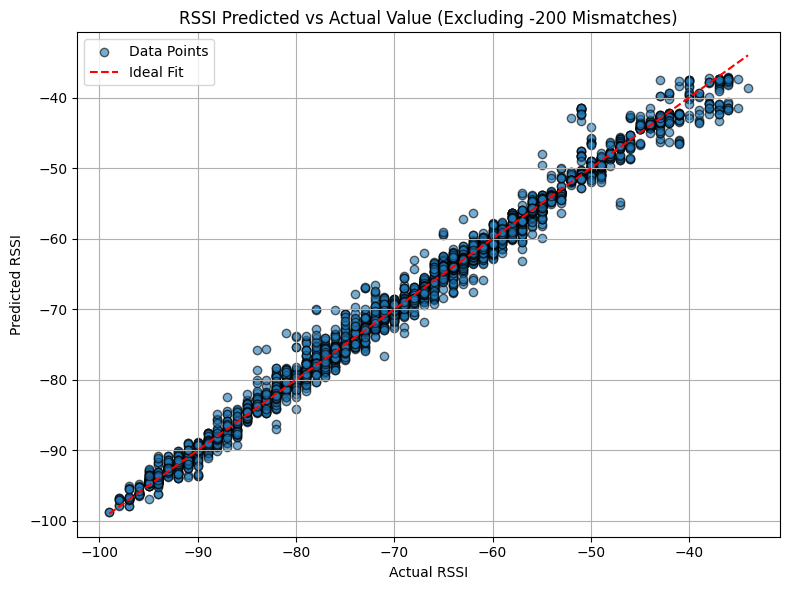

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure y_test and y_pred_rssi are 1D arrays
combined_actual = y_test
combined_predicted = y_pred_rssi

mask = (combined_actual != -200) & (combined_predicted != -200)
combined_actual = combined_actual[mask]
combined_predicted = combined_predicted[mask]

# Create the scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(combined_actual, combined_predicted, alpha=0.6, edgecolors='k', label="Data Points")
plt.plot([combined_actual.min(), combined_actual.max()],
         [combined_actual.min(), combined_actual.max()], color='red', linestyle='--', label="Ideal Fit")
plt.title("RSSI Predicted vs Actual Value (Excluding -200 Mismatches)")
plt.xlabel("Actual RSSI")
plt.ylabel("Predicted RSSI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Genetic Algorithm

In [87]:
import itertools
import pygad
import random

In [88]:
filtered_data

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp,pow_ap_digilab,pow_ap_dosen,ap_x,ap_y
0,2024-10-17 08:38:31.952562400+00:00,1,3,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:38:31.952562,300,1368,30,20,867,1122
1,2024-10-17 08:39:38.608620600+00:00,1,1,DTE Staff,3,11,300,1368,-63.0,-200.0,0,08:39:38.608620,300,1367,30,20,867,1122
2,2024-10-17 08:39:45.832622300+00:00,1,1,DTE Student,4,11,300,1368,-63.0,-200.0,0,08:39:45.832622,300,1367,30,20,867,1122
3,2024-10-17 08:40:03.157448400+00:00,1,2,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:40:03.157448,300,1368,30,20,867,1122
5,2024-10-17 08:40:27.631585400+00:00,1,3,DTE Student,4,11,300,1368,-62.0,-200.0,0,08:40:27.631585,300,1368,30,20,867,1122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6514,2025-03-12 07:28:20.594572600+00:00,116,19,DTE Staff,3,6,1520,134,-72.0,-200.0,-1,07:28:20.594572,1520,139,23,30,867,1122
6515,2025-03-12 07:28:23.628276100+00:00,116,19,DTE Staff,2,11,1520,134,-200.0,-81.0,-1,07:28:23.628276,1520,134,23,30,2454,520
6516,2025-03-12 07:28:26.622391800+00:00,116,19,DTE Staff,1,11,1520,134,-200.0,-82.0,-1,07:28:26.622391,1520,133,23,30,2454,520
6519,2025-03-12 07:28:48.091094300+00:00,116,20,DTE Staff,2,11,1520,134,-200.0,-84.0,-1,07:28:48.091094,1520,134,23,30,2454,520


In [89]:
df = filtered_data.drop(columns=['time','ssid','xr','yr','iteration'])

In [90]:
# Define possible transmit power levels for each AP
power_levels = [20, 23, 26, 30]

# Genetic Algorithm Parameters
POPULATION_SIZE = 10
GENERATIONS = 10
MUTATION_RATE = 0.4
CROSSOVER_RATE = 0.7

# # Interference penalty threshold
# INTERFERENCE_THRESHOLD = -90  

In [91]:
# Extract reference points (users) from dataframe
reference_points = df['reference_point'].unique()

In [92]:
print("Sample Predicted RSSI Values:", y_pred_rssi[:10])

Sample Predicted RSSI Values: [[ -63.482    -199.99228 ]
 [ -63.048927 -199.97578 ]
 [ -63.06828  -199.97578 ]
 [ -63.610905 -199.99025 ]
 [ -63.482    -199.99228 ]
 [ -63.323807 -199.99228 ]
 [ -62.887802 -200.01086 ]
 [ -63.486885 -200.00552 ]
 [ -62.98186  -200.00523 ]
 [ -63.963123 -200.01508 ]]


In [93]:
df

,reference_point,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp,pow_ap_digilab,pow_ap_dosen,ap_x,ap_y
0,1,4,11,-64.0,-200.0,0,08:38:31.952562,300,1368,30,20,867,1122
1,1,3,11,-63.0,-200.0,0,08:39:38.608620,300,1367,30,20,867,1122
2,1,4,11,-63.0,-200.0,0,08:39:45.832622,300,1367,30,20,867,1122
3,1,4,11,-64.0,-200.0,0,08:40:03.157448,300,1368,30,20,867,1122
5,1,4,11,-62.0,-200.0,0,08:40:27.631585,300,1368,30,20,867,1122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6514,116,3,6,-72.0,-200.0,-1,07:28:20.594572,1520,139,23,30,867,1122
6515,116,2,11,-200.0,-81.0,-1,07:28:23.628276,1520,134,23,30,2454,520
6516,116,1,11,-200.0,-82.0,-1,07:28:26.622391,1520,133,23,30,2454,520
6519,116,2,11,-200.0,-84.0,-1,07:28:48.091094,1520,134,23,30,2454,520


In [94]:
# import numpy as np
# import pandas as pd
# import random

# # Genetic Algorithm Parameters
# POPULATION_SIZE = 10
# GENERATIONS = 5
# MUTATION_RATE = 0.4
# CROSSOVER_RATE = 0.7
# TOURNAMENT_SIZE = 3  # For selection diversity

# # Extract reference points (users) from dataframe
# reference_points = df['reference_point'].unique()

# # Extract unique transmit power values dynamically from the dataset
# available_power_levels = sorted(set(df[['pow_ap_digilab', 'pow_ap_dosen']].values.flatten()))

# # Function to predict RSSI for a given transmit power setting
# def predict_rssi_for_power(transmit_power_combination):
#     df_temp = df.copy()

#     # Assign transmit power values
#     df_temp['pow_ap_digilab'] = transmit_power_combination[0]
#     df_temp['pow_ap_dosen'] = transmit_power_combination[1]

#     # Define valid numeric features for RSSI prediction
#     valid_features = [col for col in df.columns if col not in ['rssi_ap_digilab', 'rssi_ap_dosen', 'reference_point', 'ssid', 'bssid']]

#     # Ensure transmit power is included in the features
#     X_test = df_temp[valid_features]  # Ensure it includes pow_ap_digilab & pow_ap_dosen

#     # Predict RSSI
#     y_pred = best_model.predict(X_test)

#     # Create a DataFrame for predictions
#     df_pred = pd.DataFrame(y_pred, columns=['pred_rssi_digilab', 'pred_rssi_ap_dosen'])

#     # Attach predictions
#     df_temp[['pred_rssi_digilab', 'pred_rssi_ap_dosen']] = df_pred

#     return df_temp


# # Function to apply roaming based on predicted RSSI (unchanged)
# def apply_roaming(df_temp):
#     roaming_users = []
#     ROAM_THRESHOLD = 3  # Only roam if new AP is significantly better

#     def update_rssi(row):
#         # Determine the currently connected AP
#         if row['rssi_ap_digilab'] != -200:
#             current_ap = 'digilab'
#             other_ap = 'dosen'
#             current_rssi = row['pred_rssi_digilab']
#             other_rssi = row['pred_rssi_ap_dosen']
#         else:
#             current_ap = 'dosen'
#             other_ap = 'digilab'
#             current_rssi = row['pred_rssi_ap_dosen']
#             other_rssi = row['pred_rssi_digilab']

#         # Apply roaming decision
#         if other_rssi > current_rssi + ROAM_THRESHOLD:
#             row[f'rssi_ap_{current_ap}'] = -200  # Disconnect from previous AP
#             row[f'rssi_ap_{other_ap}'] = other_rssi  # Connect to the new AP
#             roaming_users.append(row['reference_point'])  # Log roaming event
#         else:
#             row[f'rssi_ap_{current_ap}'] = current_rssi  # Stay with current AP

#         return row

#     df_temp = df_temp.apply(update_rssi, axis=1)
#     return df_temp, set(roaming_users)  # Return dataframe & roaming users set

# # Function to evaluate fitness (maximize total RSSI)
# def evaluate_fitness(transmit_power_combination):
#     df_updated = predict_rssi_for_power(transmit_power_combination)

#     # Apply roaming logic
#     df_updated, roaming_users = apply_roaming(df_updated)

#     total_rssi_before = df[['rssi_ap_digilab', 'rssi_ap_dosen']].replace(-200, np.nan).sum().sum()
#     total_rssi_after = df_updated[['rssi_ap_digilab', 'rssi_ap_dosen']].replace(-200, np.nan).sum().sum()

#     max_rssi_before = max(df['rssi_ap_digilab'].max(), df['rssi_ap_dosen'].max())
#     max_rssi_after = max(df_updated['rssi_ap_digilab'].max(), df_updated['rssi_ap_dosen'].max())

#     roaming_change = len(roaming_users) * 100  # Reward systems that increase roaming

#     # Updated fitness formula
#     fitness = ((total_rssi_after - total_rssi_before) * 10 +
#                (max_rssi_after - max_rssi_before) * 100 +
#                roaming_change)

#     return fitness, roaming_users, total_rssi_before, total_rssi_after, max_rssi_before, max_rssi_after


# # Tournament Selection Function (unchanged)
# def tournament_selection(population, fitness_scores, tournament_size=TOURNAMENT_SIZE):
#     selected = random.sample(list(zip(fitness_scores, population)), tournament_size)
#     selected.sort(key=lambda x: x[0], reverse=True)  # Sort by fitness (higher is better)
#     return list(selected[0][1])  # Ensure it returns the selected individual's transmit power settings

# # Function to perform crossover (unchanged)
# def crossover(parent1, parent2):
#     if not isinstance(parent1, list):
#         parent1 = [parent1] * 2  # Ensure it's a list with two values
#     if not isinstance(parent2, list):
#         parent2 = [parent2] * 2  # Ensure it's a list with two values

#     if random.random() < CROSSOVER_RATE:
#         child1 = [random.choice([parent1[0], parent2[0]]), random.choice([parent1[1], parent2[1]])]
#         child2 = [random.choice([parent1[0], parent2[0]]), random.choice([parent1[1], parent2[1]])]
#         return child1, child2
#     return parent1, parent2  # Ensure two lists are always returned



# # Function to perform mutation (modifies existing values using available power levels)
# def mutate(individual):
#     # Ensure individual is a list
#     if not isinstance(individual, list):
#         individual = [individual]  # Convert single value to a list with one element

#     if random.random() < MUTATION_RATE:
#         mutate_index = random.randint(0, 1)
#         individual[mutate_index] = random.choice([p for p in available_power_levels if p != individual[mutate_index]])

#         # Occasionally mutate **both values** for more variation
#         if random.random() < 0.2:  # 20% chance
#             other_index = 1 - mutate_index
#             individual[other_index] = random.choice([p for p in available_power_levels if p != individual[other_index]])

#     return individual

# # Function to initialize population dynamically based on reference point values
# def initialize_population():
#     population = []
#     for _ in range(POPULATION_SIZE):
#         ref_point = random.choice(reference_points)
#         # Randomize power levels more effectively
#         transmit_power_combo = [
#             random.choice(df['pow_ap_digilab'].unique()),
#             random.choice(df['pow_ap_dosen'].unique())
#         ]
#         population.append(transmit_power_combo)
#     return population


# # Main Genetic Algorithm Loop
# population = initialize_population()
# best_fitness_history = []

# for generation in range(GENERATIONS):
#     fitness_scores = []
    
#     # Evaluate fitness for each individual
#     for individual in population:
#         fitness, roaming_users, total_rssi_before, total_rssi_after, max_rssi_before, max_rssi_after = evaluate_fitness(individual)
#         fitness_scores.append((fitness, individual, roaming_users, total_rssi_before, total_rssi_after, max_rssi_before, max_rssi_after))

#     # Sort population by fitness (descending order)
#     fitness_scores.sort(reverse=True, key=lambda x: x[0])
#     best_individual = fitness_scores[0][1]
#     best_fitness_history.append(fitness_scores[0][0])

#     # Print the results
#     print(f"\nGeneration {generation + 1}:")
#     print(f"Best Transmit Power: {best_individual}")
#     print(f"Fitness: {fitness_scores[0][0]}")
#     print(f"Roaming Users: {len(fitness_scores[0][2])}, Reference Points That Roamed: {fitness_scores[0][2]}")
#     print(f"Total RSSI Before: {fitness_scores[0][3]:.2f}, After: {fitness_scores[0][4]:.2f}")
#     print(f"Max RSSI Before: {fitness_scores[0][5]:.2f}, After: {fitness_scores[0][6]:.2f}")

#     # Selection using tournament selection instead of always keeping the best
#     new_population = [tournament_selection(population, [x[0] for x in fitness_scores]) for _ in range(POPULATION_SIZE // 2)]

#     # Crossover & Mutation to generate new individuals
#     while len(new_population) < POPULATION_SIZE:
#         parent1, parent2 = random.sample(new_population, 2)
#         child1, child2 = crossover(parent1, parent2)
#         new_population.append(mutate(child1))
#         new_population.append(mutate(child2))

#     # Update population
#     population = new_population

# # Best transmit power combination after all generations
# print(f"\nOptimal Transmit Power: {best_individual}")


# Pathloss

In [95]:
filtered_data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp,pow_ap_digilab,pow_ap_dosen,ap_x,ap_y
3070,2025-03-01 02:03:36.473667+00:00,81,12,DTE Student,4,1,2000,639,-60.0,-200.0,0,02:03:36.473667,2000,638,23,30,867,1122
3900,2025-03-01 04:06:56.740612700+00:00,69,19,DTE Staff,2,11,2000,1567,-200.0,-94.0,0,04:06:56.740612,2000,1569,26,26,2454,520
1668,2024-10-23 09:00:34.018545200+00:00,33,12,DTE Student,4,11,1449,1037,-48.0,-200.0,1,09:00:34.018545,1449,1036,30,23,867,1122
235,2024-10-17 09:38:12.136976300+00:00,6,4,DTE Student,4,11,529,1368,-66.0,-200.0,0,09:38:12.136976,529,1367,30,20,867,1122
2043,2025-02-25 03:47:43.646549+00:00,114,2,DTE Staff,2,11,1290,639,-200.0,-78.0,0,03:47:43.646549,1290,639,26,26,2454,520


In [96]:
df_final = filtered_data.drop(columns=['time', 'time_numeric','ssid','xr','yr'])

In [97]:
df_final.sample(5)

,reference_point,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position,xp,yp,pow_ap_digilab,pow_ap_dosen,ap_x,ap_y
1533,39,18,3,11,-59.0,-200.0,1,2224,1038,20,30,867,1122
1634,33,3,1,1,-200.0,-89.0,1,1449,1039,30,23,2454,520
5416,27,3,2,11,-200.0,-93.0,-1,759,1037,30,20,2454,520
2219,118,9,3,1,-61.0,-200.0,0,1520,470,26,26,867,1122
2403,120,17,4,1,-58.0,-200.0,0,1520,838,26,26,867,1122


In [ ]:
# ===== Parameters =====
path_loss_exponent = 2.7
noise_std = 2  # dB standard deviation

# Possible power levels
power_levels = [20, 23, 26, 30]

# Get unique locations
locations = df_final[['reference_point', 'xp', 'yp']].drop_duplicates()

data = []

for _, row in locations.iterrows():
    ref = row['reference_point']
    x, y = row['xp'], row['yp']

    # Distance to APs
    d_digilab = np.sqrt((x - 867)**2 + (y - 1122)**2)
    d_dosen = np.sqrt((x - 2454)**2 + (y - 520)**2)

    for pow_digilab in power_levels:
        for pow_dosen in power_levels:
            # Synthetic RSSI
            rssi_digilab = pow_digilab - 10 * path_loss_exponent * np.log10(d_digilab + 1) + np.random.normal(0, noise_std)
            rssi_dosen = pow_dosen - 10 * path_loss_exponent * np.log10(d_dosen + 1) + np.random.normal(0, noise_std)

            data.append({
                'reference_point': ref,
                'xp': x,
                'yp': y,
                'pow_ap_digilab': pow_digilab,
                'pow_ap_dosen': pow_dosen,
                'rssi_ap_digilab': rssi_digilab,
                'rssi_ap_dosen': rssi_dosen
            })

df_synthetic = pd.DataFrame(data)
print(df_synthetic.head())


In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from itertools import product

# ===== 1. Prepare Data =====
feature_cols = ['xp', 'yp', 'pow_ap_digilab', 'pow_ap_dosen']
rssi_cols = ['rssi_ap_digilab', 'rssi_ap_dosen']

X = df_synthetic[feature_cols]
y = df_synthetic[rssi_cols]

# ===== 2. Split & Train =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
model.fit(X_train, y_train)

# ===== 3. Power Breathing Simulation =====
power_levels = [20, 23, 26, 30]
results = []

# Evaluate total RSSI over all locations
unique_locations = df_synthetic[['reference_point', 'xp', 'yp']].drop_duplicates()

for comb in product(power_levels, repeat=2):
    pow_digilab, pow_dosen = comb

    # Prepare evaluation set
    eval_data = []
    for _, row in unique_locations.iterrows():
        eval_data.append({
            'xp': row['xp'],
            'yp': row['yp'],
            'pow_ap_digilab': pow_digilab,
            'pow_ap_dosen': pow_dosen,
            'reference_point': row['reference_point']
        })

    df_eval = pd.DataFrame(eval_data)
    X_eval = df_eval[['xp', 'yp', 'pow_ap_digilab', 'pow_ap_dosen']]
    y_pred = model.predict(X_eval)

    # Aggregate best RSSI per location
    df_pred = pd.DataFrame(y_pred, columns=['rssi_ap_digilab', 'rssi_ap_dosen'])
    df_pred['reference_point'] = df_eval['reference_point']

    best_rssi_per_loc = (
        df_pred
        .groupby('reference_point')
        .apply(lambda x: x[['rssi_ap_digilab', 'rssi_ap_dosen']].max(axis=1).mean(), include_groups=False)
    )

    total_rssi = best_rssi_per_loc.sum()

    results.append((comb, total_rssi))

# ===== 4. Show Result =====
best_comb, best_total_rssi = max(results, key=lambda x: x[1])

print(f"\nBest Power Combination: {best_comb}")
print(f"Total RSSI Score (closer to 0 is better): {best_total_rssi}")
print("\nAll evaluated combinations:")
for r in results:
    print(r)


Best Power Combination: (30, 30)
Total RSSI Score (closer to 0 is better): -4768.85888671875

All evaluated combinations:
((20, 20), -5814.375)
((20, 23), -5741.3945)
((20, 26), -5615.1104)
((20, 30), -5418.0635)
((23, 20), -5566.7236)
((23, 23), -5504.3057)
((23, 26), -5420.6035)
((23, 30), -5275.1455)
((26, 20), -5263.9805)
((26, 23), -5238.078)
((26, 26), -5180.145)
((26, 30), -5074.9097)
((30, 20), -4868.9287)
((30, 23), -4878.7217)
((30, 26), -4828.6357)
((30, 30), -4768.859)


In [99]:
# 1. Compute distances from each unique reference point to both APs

# Access Point coordinates (static)
ap_digilab = (867, 1122)
ap_dosen = (2454, 520)

# Get all unique location points (fingerprinting locations)
locations = df_final[['reference_point', 'xp', 'yp']].drop_duplicates()

# Compute distances and show sample
locations['dist_to_digilab'] = np.sqrt((locations['xp'] - ap_digilab[0])**2 + (locations['yp'] - ap_digilab[1])**2)
locations['dist_to_dosen'] = np.sqrt((locations['xp'] - ap_dosen[0])**2 + (locations['yp'] - ap_dosen[1])**2)

print("📍 Sample of distances to each AP:")
print(locations.head())


📍 Sample of distances to each AP:
    reference_point   xp    yp  dist_to_digilab  dist_to_dosen
0                 1  300  1368       618.065531    2314.912525
1                 1  300  1367       617.668196    2314.546392
12                1  300  1369       618.464227    2315.279033
41                2  300  1568       721.391017    2395.416456
48                2  300  1565       719.540131    2394.105470


In [100]:
# 2. Generate synthetic RSSI values for all power combinations at each location
# RSSI = Transmit Power - Path Loss + Gaussian Noise

path_loss_exponent = 2.7
noise_std = 2
power_levels = [20, 23, 26, 30]

data = []

for _, row in locations.iterrows():
    for pow_digilab in power_levels:
        for pow_dosen in power_levels:
            rssi_digilab = pow_digilab - 10 * path_loss_exponent * np.log10(row['dist_to_digilab'] + 1) + np.random.normal(0, noise_std)
            rssi_dosen = pow_dosen - 10 * path_loss_exponent * np.log10(row['dist_to_dosen'] + 1) + np.random.normal(0, noise_std)
            
            data.append({
                'reference_point': row['reference_point'],
                'xp': row['xp'],
                'yp': row['yp'],
                'pow_ap_digilab': pow_digilab,
                'pow_ap_dosen': pow_dosen,
                'rssi_ap_digilab': rssi_digilab,
                'rssi_ap_dosen': rssi_dosen
            })

df_synthetic = pd.DataFrame(data)

print("\n📡 Sample of synthetic RSSI data:")
print(df_synthetic.head())



📡 Sample of synthetic RSSI data:
   reference_point     xp      yp  pow_ap_digilab  pow_ap_dosen  \
0              1.0  300.0  1368.0              20            20   
1              1.0  300.0  1368.0              20            23   
2              1.0  300.0  1368.0              20            26   
3              1.0  300.0  1368.0              20            30   
4              1.0  300.0  1368.0              23            20   

   rssi_ap_digilab  rssi_ap_dosen  
0       -55.708211     -71.384139  
1       -54.211737     -70.052619  
2       -57.260844     -66.331055  
3       -58.354088     -60.556432  
4       -52.213128     -67.216924  


In [103]:
from sklearn.model_selection import train_test_split

# Features and targets
feature_cols = ['xp', 'yp', 'pow_ap_digilab', 'pow_ap_dosen']
target_cols = ['rssi_ap_digilab', 'rssi_ap_dosen']

X = df_synthetic[feature_cols]
y = df_synthetic[target_cols]

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [104]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [105]:
from itertools import product

# We want to test: for each location, what happens at every power combo
# This simulates applying a single power setting globally to the network

eval_data = []

for comb in product(power_levels, repeat=2):
    for _, row in locations.iterrows():
        eval_data.append({
            'reference_point': row['reference_point'],
            'xp': row['xp'],
            'yp': row['yp'],
            'pow_ap_digilab': comb[0],
            'pow_ap_dosen': comb[1]
        })

df_eval = pd.DataFrame(eval_data)

print("\nSample of evaluation dataset (each row = 1 location under 1 power combo):")
print(df_eval.head())


Sample of evaluation dataset (each row = 1 location under 1 power combo):
   reference_point     xp      yp  pow_ap_digilab  pow_ap_dosen
0              1.0  300.0  1368.0              20            20
1              1.0  300.0  1367.0              20            20
2              1.0  300.0  1369.0              20            20
3              2.0  300.0  1568.0              20            20
4              2.0  300.0  1565.0              20            20


In [106]:
X_eval = df_eval[['xp', 'yp', 'pow_ap_digilab', 'pow_ap_dosen']]
y_pred = model.predict(X_eval)

df_pred = pd.DataFrame(y_pred, columns=['rssi_ap_digilab', 'rssi_ap_dosen'])
df_pred['reference_point'] = df_eval['reference_point'].values
df_pred['power_comb'] = list(zip(df_eval['pow_ap_digilab'], df_eval['pow_ap_dosen']))

print("\n📈 Predicted RSSI sample:")
print(df_pred.head())


📈 Predicted RSSI sample:
   rssi_ap_digilab  rssi_ap_dosen  reference_point power_comb
0       -55.077446     -68.600700              1.0   (20, 20)
1       -54.272518     -69.748009              1.0   (20, 20)
2       -55.092484     -69.139160              1.0   (20, 20)
3       -58.897263     -69.067169              2.0   (20, 20)
4       -57.757702     -68.922546              2.0   (20, 20)


In [107]:
model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [108]:
# We want to test: for each location, what happens at every power combo
# This simulates applying a single power setting globally to the network

eval_data = []

for comb in product(power_levels, repeat=2):
    for _, row in locations.iterrows():
        eval_data.append({
            'reference_point': row['reference_point'],
            'xp': row['xp'],
            'yp': row['yp'],
            'pow_ap_digilab': comb[0],
            'pow_ap_dosen': comb[1]
        })

df_eval = pd.DataFrame(eval_data)

print("\nSample of evaluation dataset (each row = 1 location under 1 power combo):")
print(df_eval.head())


Sample of evaluation dataset (each row = 1 location under 1 power combo):
   reference_point     xp      yp  pow_ap_digilab  pow_ap_dosen
0              1.0  300.0  1368.0              20            20
1              1.0  300.0  1367.0              20            20
2              1.0  300.0  1369.0              20            20
3              2.0  300.0  1568.0              20            20
4              2.0  300.0  1565.0              20            20


In [110]:
X_eval = df_eval[['xp', 'yp', 'pow_ap_digilab', 'pow_ap_dosen']]
y_pred = model.predict(X_eval)

df_pred = pd.DataFrame(y_pred, columns=['rssi_ap_digilab', 'rssi_ap_dosen'])
df_pred['reference_point'] = df_eval['reference_point'].values
df_pred['power_comb'] = list(zip(df_eval['pow_ap_digilab'], df_eval['pow_ap_dosen']))

print("\nPredicted RSSI sample:")
print(df_pred.head())


Predicted RSSI sample:
   rssi_ap_digilab  rssi_ap_dosen  reference_point power_comb
0       -55.077446     -68.600700              1.0   (20, 20)
1       -54.272518     -69.748009              1.0   (20, 20)
2       -55.092484     -69.139160              1.0   (20, 20)
3       -58.897263     -69.067169              2.0   (20, 20)
4       -57.757702     -68.922546              2.0   (20, 20)


In [116]:
results = []

for comb in product(power_levels, repeat=2):
    df_sub = df_pred[df_pred['power_comb'] == comb]
    
    # For each reference point: get best RSSI (digilab vs dosen), then average across samples
    best_rssi_per_loc = (
        df_sub.groupby('reference_point')[['rssi_ap_digilab', 'rssi_ap_dosen']]
        .apply(lambda x: x.max(axis=1).mean())
    )

    total_rssi = best_rssi_per_loc.sum()
    results.append((comb, total_rssi))

# Find best combination
best_comb, best_score = max(results, key=lambda x: x[1])

# Print best combo and full results
print(f"\nBest Power Combination: {best_comb}")
print(f"Total RSSI Score: {best_score:.8f}\n")

print("All evaluated combinations:")
for comb, score in results:
    print(f"{comb}: {score:.4f}")


Best Power Combination: (30, 30)
Total RSSI Score: -4771.15722656

All evaluated combinations:
(20, 20): -5830.6216
(20, 23): -5742.1611
(20, 26): -5627.6455
(20, 30): -5421.7549
(23, 20): -5548.0615
(23, 23): -5494.1021
(23, 26): -5406.5015
(23, 30): -5270.5312
(26, 20): -5282.2539
(26, 23): -5247.1855
(26, 26): -5163.3613
(26, 30): -5068.2075
(30, 20): -4894.3691
(30, 23): -4868.5698
(30, 26): -4824.8574
(30, 30): -4771.1572


In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print("\n📊 Model Accuracy:")
print(f"🔹 MSE: {mse:.4f}")
print(f"🔹 MAE: {mae:.4f}")
print(f"🔹 R²:  {r2:.4f}")


📊 Model Accuracy:
🔹 MSE: 4.8304
🔹 MAE: 1.7419
🔹 R²:  0.9162


In [120]:
# Ensure 'locations' has reference_point, xp, yp
locations = df_final[['reference_point', 'xp', 'yp']].drop_duplicates()

# Add coordinates back into prediction DataFrame
df_pred = df_pred.merge(locations, on='reference_point', how='left')

# Verify
print("Added coordinates to df_pred:")
print(df_pred[['reference_point', 'xp', 'yp']].head())


Added coordinates to df_pred:
   reference_point   xp    yp
0              1.0  300  1368
1              1.0  300  1367
2              1.0  300  1369
3              1.0  300  1368
4              1.0  300  1367


In [121]:
df_overlay = df_pred.groupby(['reference_point', 'xp', 'yp'])[['rssi_ap_digilab', 'rssi_ap_dosen']].max().reset_index()
df_overlay['best_rssi'] = df_overlay[['rssi_ap_digilab', 'rssi_ap_dosen']].max(axis=1)

🧭 Sample coordinates in overlay:
         reference_point   xp    yp  best_rssi
2893605              1.0  300  1368  -44.91848
2893606              1.0  300  1367  -44.91848
2893607              1.0  300  1369  -44.91848
2893608              1.0  300  1368  -44.91848
2893609              1.0  300  1367  -44.91848


C:\Users\laure\AppData\Local\Temp\ipykernel_17352\3937232675.py:46: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


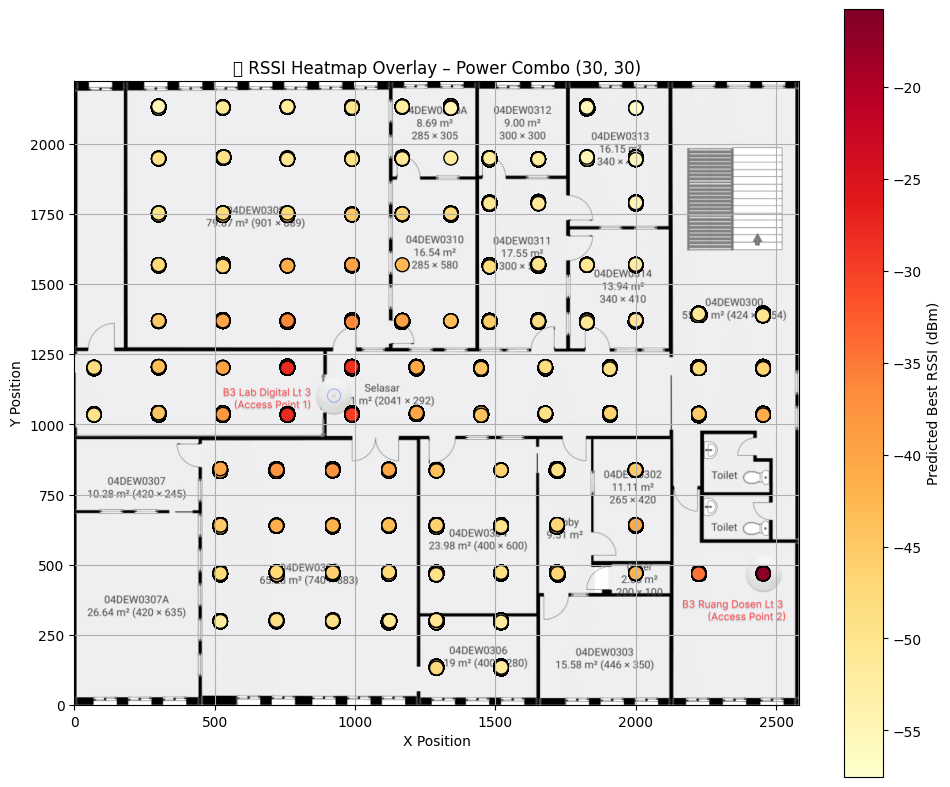

In [127]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# === 1. Load floorplan ===
floorplan = mpimg.imread('Data/floorplan.png')  # ✅ Change path if needed

# === 2. Get location coordinates (reference_point, xp, yp) ===
locations = df_final[['reference_point', 'xp', 'yp']].drop_duplicates()

# === 3. Add best RSSI and coordinates into prediction dataframe ===
df_pred_full = df_pred.copy()

# Add power_comb column if not already there
if 'power_comb' not in df_pred_full.columns:
    df_pred_full['power_comb'] = list(zip(df_eval['pow_ap_digilab'], df_eval['pow_ap_dosen']))

# Add best RSSI
df_pred_full['best_rssi'] = df_pred_full[['rssi_ap_digilab', 'rssi_ap_dosen']].max(axis=1)

# Add coordinates by merging with reference point info
df_pred_full = df_pred_full.merge(locations, on='reference_point', how='left')

# ✅ Now filter the best power combination
df_overlay = df_pred_full[df_pred_full['power_comb'] == best_comb].copy()

# Final check: make sure xp and yp are there
print("🧭 Sample coordinates in overlay:")
print(df_overlay[['reference_point', 'xp', 'yp', 'best_rssi']].head())

# === 4. Plot overlay on floorplan ===
plt.figure(figsize=(10, 8))
plt.imshow(floorplan, extent=[0, floorplan.shape[1], floorplan.shape[0], 0])  # adjust if needed

scatter = plt.scatter(
    df_overlay['xp'], df_overlay['yp'],
    c=df_overlay['best_rssi'],
    cmap='YlOrRd', s=100, edgecolors='black'
)

plt.colorbar(scatter, label='Predicted Best RSSI (dBm)')
plt.title(f"📍 RSSI Heatmap Overlay – Power Combo {best_comb}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


# Greedy Algorithm

In [159]:
from itertools import product

def get_total_rssi_score(model, locations, power_comb):
    pow_digilab, pow_dosen = power_comb
    eval_data = pd.DataFrame({
        'xp': locations['xp'],
        'yp': locations['yp'],
        'pow_ap_digilab': pow_digilab,
        'pow_ap_dosen': pow_dosen
    })

    preds = model.predict(eval_data)
    best_rssi = np.max(preds, axis=1)  # best of digilab or dosen per location
    return best_rssi.sum()

def get_neighbors(current_comb, power_levels):
    neighbors = []
    steps = [-1, 1]

    for i, p in enumerate(current_comb):
        idx = power_levels.index(p)
        for step in steps:
            new_idx = idx + step
            if 0 <= new_idx < len(power_levels):
                new_comb = list(current_comb)
                new_comb[i] = power_levels[new_idx]
                neighbors.append(tuple(new_comb))
    return neighbors

In [161]:
# Start from lowest power setting
start_comb = (20, 20)
visited = set()
current_comb = start_comb
best_score = get_total_rssi_score(model, locations, current_comb)
history = [(current_comb, best_score)]

print(f"🔍 Starting Greedy Search from {start_comb} (score = {best_score:.2f})")

while True:
    neighbors = get_neighbors(current_comb, power_levels)
    improved = False
    for neighbor in neighbors:
        if neighbor in visited:
            continue
        score = get_total_rssi_score(model, locations, neighbor)
        history.append((neighbor, score))
        if score > best_score:
            current_comb = neighbor
            best_score = score
            improved = True
            break
    if not improved:
        break
    visited.add(current_comb)

print(f"\n🏁 Greedy Search completed.")
print(f"Best Power Combination: {current_comb}")
print(f"Total RSSI Score: {best_score:.4f}")

🔍 Starting Greedy Search from (20, 20) (score = -30490.53)

🏁 Greedy Search completed.
Best Power Combination: (30, 30)
Total RSSI Score: -25007.3984


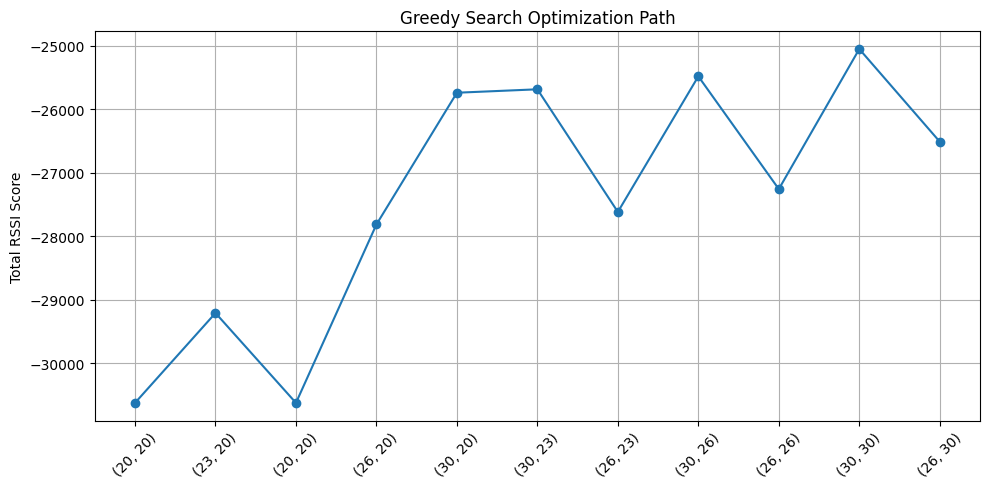

In [ ]:
import matplotlib.pyplot as plt

steps = [str(h[0]) for h in history]
scores = [h[1] for h in history]

plt.figure(figsize=(10, 5))
plt.plot(range(len(scores)), scores, marker='o')
plt.xticks(range(len(scores)), steps, rotation=45)
plt.ylabel('Total RSSI Score')
plt.title('Greedy Search Optimization Path')
plt.grid(True)
plt.tight_layout()
plt.show()


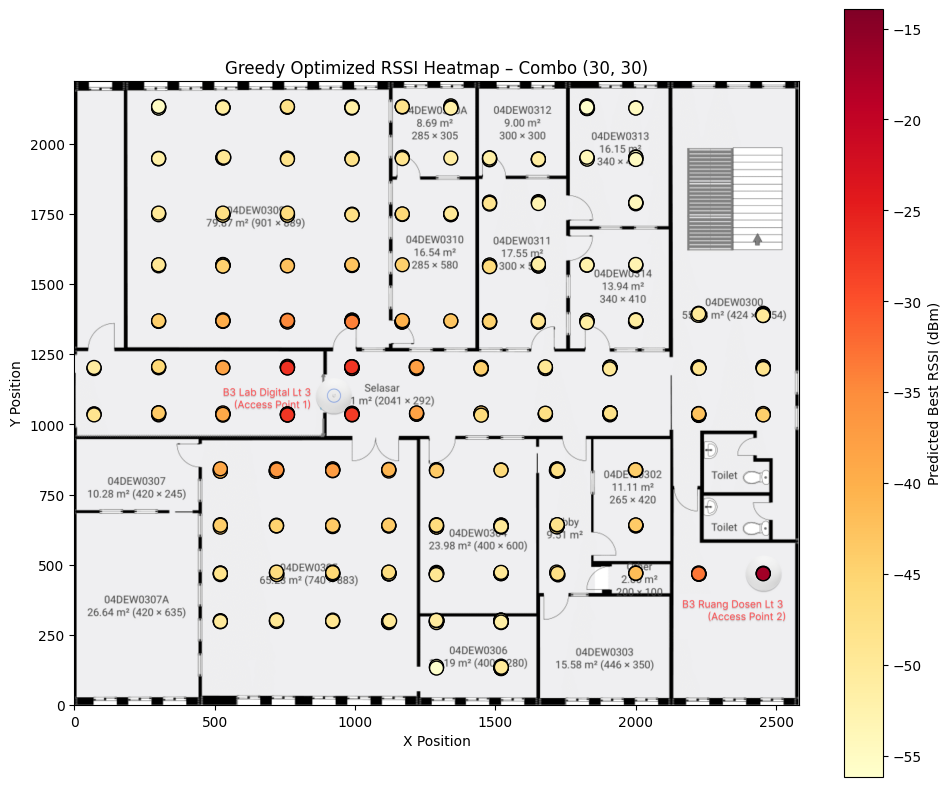

In [ ]:
import matplotlib.image as mpimg

# Predict best RSSI per location with final power combo
eval_data = pd.DataFrame({
    'xp': locations['xp'],
    'yp': locations['yp'],
    'pow_ap_digilab': current_comb[0],
    'pow_ap_dosen': current_comb[1]
})
preds = model.predict(eval_data)

df_overlay = locations.copy()
df_overlay['rssi_ap_digilab'] = preds[:, 0]
df_overlay['rssi_ap_dosen'] = preds[:, 1]
df_overlay['best_rssi'] = df_overlay[['rssi_ap_digilab', 'rssi_ap_dosen']].max(axis=1)

# Load floorplan
floorplan = mpimg.imread('Data/floorplan.png')

# Plot overlay
plt.figure(figsize=(10, 8))
plt.imshow(floorplan, extent=[0, floorplan.shape[1], floorplan.shape[0], 0])
scatter = plt.scatter(df_overlay['xp'], df_overlay['yp'],
                      c=df_overlay['best_rssi'], cmap='YlOrRd',
                      s=100, edgecolors='black')

plt.gca().invert_yaxis()
plt.colorbar(scatter, label='Predicted Best RSSI (dBm)')
plt.title(f"Greedy Optimized RSSI Heatmap – Combo {current_comb}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.tight_layout()
plt.show()


# Genetic Algorithm

In [171]:
from sklearn.metrics import mean_squared_error

def fitness(individual, model, locations, df_synthetic=None):
    pow_digilab, pow_dosen = individual

    # Prediction input
    X_eval = pd.DataFrame({
        'xp': locations['xp'],
        'yp': locations['yp'],
        'pow_ap_digilab': pow_digilab,
        'pow_ap_dosen': pow_dosen
    })

    preds = model.predict(X_eval)
    best_rssi = np.max(preds, axis=1)
    total_rssi = best_rssi.sum()

    # Optional MSE against synthetic ground truth
    mse = None
    if df_synthetic is not None:
        gt = df_synthetic[
            (df_synthetic['pow_ap_digilab'] == pow_digilab) &
            (df_synthetic['pow_ap_dosen'] == pow_dosen)
        ].copy()

        gt = gt.sort_values('reference_point').reset_index(drop=True)
        preds_df = pd.DataFrame(preds, columns=['rssi_ap_digilab', 'rssi_ap_dosen'])
        
        rmse = np.sqrt(mean_squared_error(gt[['rssi_ap_digilab', 'rssi_ap_dosen']], preds_df))
        mse = mean_squared_error(gt[['rssi_ap_digilab', 'rssi_ap_dosen']], preds_df)

    return total_rssi, mse

In [168]:
import random

def run_genetic_algorithm(model, locations, df_synthetic=None, generations=10, pop_size=8, mutation_rate=0.2):
    power_levels = [20, 23, 26, 30]

    # Random population
    population = [tuple(random.choices(power_levels, k=2)) for _ in range(pop_size)]
    scores = {}

    for gen in range(generations):
        print(f"\n🌱 Generation {gen+1}")
        population = list(set(population))  # remove duplicates
        evaluated = []

        for ind in population:
            score, mse = fitness(ind, model, locations, df_synthetic)
            scores[ind] = (score, mse)
            evaluated.append((ind, score, mse))
            print(f"  {ind} → RSSI: {score:.2f}, MSE: {mse:.4f}")

        # Select top 50% as parents
        evaluated.sort(key=lambda x: x[1], reverse=True)
        parents = [x[0] for x in evaluated[:len(evaluated)//2]]

        # Crossover to make new children
        children = []

        if len(parents) >= 2:
            while len(children) < pop_size - len(parents):
                p1, p2 = random.sample(parents, 2)
                child = (
                    random.choice([p1[0], p2[0]]),
                    random.choice([p1[1], p2[1]])
                )
                children.append(child)

            # Mutation
            for i in range(len(children)):
                if random.random() < mutation_rate:
                    mutated = list(children[i])
                    mutate_idx = random.choice([0, 1])
                    mutated[mutate_idx] = random.choice(power_levels)
                    children[i] = tuple(mutated)

            population = parents + children

        else:
            print("⚠️ Too few parents to continue crossover — stopping early.")
            break


    # Return best combo
    best_ind, (best_score, best_mse) = max(scores.items(), key=lambda x: x[1][0])
    return best_ind, best_score, best_mse, scores


In [172]:
best_ind, best_score, best_mse, scores = run_genetic_algorithm(
    model=model,
    locations=locations,
    df_synthetic=df_synthetic,
    generations=10,
    pop_size=12
)

print(f"\n🏆 GA Best Power Combination: {best_ind}")
print(f"📶 Total RSSI Score: {best_score:.4f}")

from sklearn.metrics import mean_absolute_error, mean_squared_error



print(f"📏 MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")



🌱 Generation 1
  (20, 30) → RSSI: -28256.62, MSE: 73.8949
  (26, 30) → RSSI: -26557.66, MSE: 74.2196
  (23, 20) → RSSI: -29208.16, MSE: 74.3671
  (23, 26) → RSSI: -28376.42, MSE: 75.5813
  (26, 20) → RSSI: -27831.06, MSE: 76.8786
  (20, 23) → RSSI: -30055.86, MSE: 70.9382
  (26, 23) → RSSI: -27637.48, MSE: 75.4591
  (30, 26) → RSSI: -25447.54, MSE: 73.8677

🌱 Generation 2
  (26, 23) → RSSI: -27637.48, MSE: 75.4591
  (30, 26) → RSSI: -25447.54, MSE: 73.8677
  (26, 30) → RSSI: -26557.66, MSE: 74.2196
  (26, 20) → RSSI: -27831.06, MSE: 76.8786

🌱 Generation 3
  (30, 30) → RSSI: -25007.40, MSE: 76.0065
  (30, 26) → RSSI: -25447.54, MSE: 73.8677
  (26, 30) → RSSI: -26557.66, MSE: 74.2196
  (23, 26) → RSSI: -28376.42, MSE: 75.5813

🌱 Generation 4
  (30, 30) → RSSI: -25007.40, MSE: 76.0065
  (30, 20) → RSSI: -25810.71, MSE: 75.4346
  (30, 26) → RSSI: -25447.54, MSE: 73.8677
⚠️ Too few parents to continue crossover — stopping early.

🏆 GA Best Power Combination: (30, 30)
📶 Total RSSI Score: -

# Limited Knowledge Model Optimization (LKMO)

In [173]:
import random

def sample_combinations(power_levels, n_samples):
    all_combinations = list(product(power_levels, repeat=2))
    return random.sample(all_combinations, min(n_samples, len(all_combinations)))


In [174]:
initial_samples = sample_combinations(power_levels, n_samples=6)

df_lkmo_train = df_synthetic[
    df_synthetic[['pow_ap_digilab', 'pow_ap_dosen']].apply(tuple, axis=1).isin(initial_samples)
].copy()

print("🔹 Initial LKMO training set:\n", df_lkmo_train[['pow_ap_digilab', 'pow_ap_dosen']].drop_duplicates())


🔹 Initial LKMO training set:
     pow_ap_digilab  pow_ap_dosen
0               20            20
2               20            26
8               26            20
9               26            23
10              26            26
13              30            23


In [175]:
X_lkmo = df_lkmo_train[['xp', 'yp', 'pow_ap_digilab', 'pow_ap_dosen']]
y_lkmo = df_lkmo_train[['rssi_ap_digilab', 'rssi_ap_dosen']]

model_lkmo = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
model_lkmo.fit(X_lkmo, y_lkmo)

print("✅ LKMO initial model trained.")


✅ LKMO initial model trained.


In [176]:
from sklearn.metrics import mean_squared_error

def evaluate_combo(model, locations, combo, df_synthetic):
    pow_digilab, pow_dosen = combo
    X_eval = pd.DataFrame({
        'xp': locations['xp'],
        'yp': locations['yp'],
        'pow_ap_digilab': pow_digilab,
        'pow_ap_dosen': pow_dosen
    })
    preds = model.predict(X_eval)
    best_rssi = np.max(preds, axis=1)
    total_rssi = best_rssi.sum()

    gt = df_synthetic[
        (df_synthetic['pow_ap_digilab'] == pow_digilab) &
        (df_synthetic['pow_ap_dosen'] == pow_dosen)
    ].sort_values('reference_point').reset_index(drop=True)
    pred_df = pd.DataFrame(preds, columns=['rssi_ap_digilab', 'rssi_ap_dosen'])
    mse = mean_squared_error(gt[['rssi_ap_digilab', 'rssi_ap_dosen']], pred_df)

    return total_rssi, mse


In [177]:
all_combos = list(product(power_levels, repeat=2))
evaluated = {tuple(x): None for x in all_combos}
evaluated.update({s: 'train' for s in initial_samples})

best_combo = None
best_score = -np.inf

for i in range(5):  # 5 iterations
    print(f"\n🔁 LKMO Iteration {i+1}")

    # Evaluate all unexplored combinations
    unexplored = [c for c in evaluated if evaluated[c] is None]
    scores = []
    for combo in unexplored:
        score, _ = evaluate_combo(model_lkmo, locations, combo, df_synthetic)
        scores.append((combo, score))

    # Pick best unexplored
    top_combo = max(scores, key=lambda x: x[1])[0]
    print(f"🔎 Exploring combo: {top_combo}")

    # Add to training data
    new_data = df_synthetic[
        (df_synthetic['pow_ap_digilab'] == top_combo[0]) &
        (df_synthetic['pow_ap_dosen'] == top_combo[1])
    ]
    df_lkmo_train = pd.concat([df_lkmo_train, new_data], ignore_index=True)
    evaluated[top_combo] = 'used'

    # Retrain model
    model_lkmo.fit(
        df_lkmo_train[['xp', 'yp', 'pow_ap_digilab', 'pow_ap_dosen']],
        df_lkmo_train[['rssi_ap_digilab', 'rssi_ap_dosen']]
    )

    # Update best
    score, _ = evaluate_combo(model_lkmo, locations, top_combo, df_synthetic)
    if score > best_score:
        best_score = score
        best_combo = top_combo



🔁 LKMO Iteration 1
🔎 Exploring combo: (30, 26)

🔁 LKMO Iteration 2
🔎 Exploring combo: (30, 30)

🔁 LKMO Iteration 3
🔎 Exploring combo: (30, 20)

🔁 LKMO Iteration 4
🔎 Exploring combo: (26, 30)

🔁 LKMO Iteration 5
🔎 Exploring combo: (20, 30)


In [178]:
final_score, final_mse = evaluate_combo(model_lkmo, locations, best_combo, df_synthetic)

print("\n🏁 LKMO Completed")
print(f"🏆 Best Power Combo: {best_combo}")
print(f"📶 Total RSSI Score: {final_score:.4f}")
print(f"📏 MSE of Best Combo: {final_mse:.4f}")



🏁 LKMO Completed
🏆 Best Power Combo: (30, 30)
📶 Total RSSI Score: -25046.6230
📏 MSE of Best Combo: 75.2695
